## 一、目的：
### 1.用tensorflow实现一个简单的卷积神经网络模型；
### 2.用Mnist手写数字训练这个模型，并且可以识别测试图片。
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

## 二、声明
### 最好了解简单的线性代数运算、python编程知识、以及卷积神经网络基本知识，可参考[ 这篇博客](http://www.enpeizhao.com/?p=332)：

## 三、流程

### 1.导入工具包

In [1]:
%matplotlib inline
#encoding:UTF-8
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math


## 2.导入数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST-data/', one_hot=True)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


## 3.查看数据基本信息

In [3]:
print "训练数据共："+str(len(data.train.images))
print "测试数据共："+str(len(data.test.images))
print "第一个测试图的维度："+str(data.test.images[0].shape)
print "第一个测试图的真实值："+str(data.test.labels[0])

训练数据共：55000
测试数据共：10000
第一个测试图的维度：(784,)
第一个测试图的真实值：[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


## 4.检测数据与标签是否对应

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28,28)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "label: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

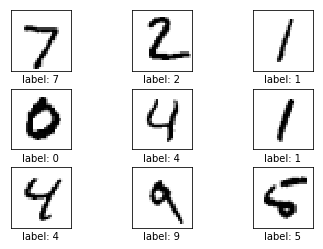

In [5]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = np.argmax(data.test.labels[0:9],1)

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)



In [6]:
# use x to get the input data [None,784]
x = tf.placeholder(dtype=tf.float32,shape=[None,784])
# reshape x to NHWC format
x_reshape = tf.reshape(tensor=x,shape=[-1,28,28,1])

# convolutional layer1 #1 


#input NHWC(Num of samples ,Heights,weights,Channels)
filter1 = tf.Variable(tf.truncated_normal(stddev=0.05,shape=[5,5,1,32]))
conv1 = tf.nn.conv2d(
    input = x_reshape,
    filter = filter1,
    strides = [1,1,1,1],
    padding = "SAME"
    
)

# biases1
biases1 = tf.Variable(tf.constant(value=0.05,shape=[32]))
# conv1 + biases1
conv1+=biases1
# relu
conv1 = tf.nn.relu(conv1)

# max pooling layer #1
pool1 = tf.nn.max_pool(
    value = conv1,
    ksize = [1,2,2,1],
    strides = [1,2,2,1],
    padding = "SAME"
)




# convolutional layer # 2
filter2 = tf.Variable(tf.truncated_normal(stddev=0.05,shape = [5,5,32,64]))
conv2 = tf.nn.conv2d(
    input = pool1,
    filter = filter2,
    strides = [1,1,1,1],
    padding = "SAME"
)

# biases 2
biases2 = tf.Variable(tf.constant(value=0.05,shape=[64]))
conv2 +=biases2

# relu
conv2 = tf.nn.relu(conv2)


#max pooling layer #2
pool2 = tf.nn.max_pool(
    value = conv2,
    ksize = [1,2,2,1],
    strides = [1,2,2,1],
    padding="SAME"
)



# flat the  [-1,7,7,64] matrix to [-1,7*7*64] matrix
flat = tf.reshape(tensor=pool2,shape=[-1,7*7*64])


fc_weigth1 = tf.Variable(tf.truncated_normal(stddev=0.05,shape=[7*7*64,128]))
fc_biases1 = tf.Variable(tf.constant(value=0.05,shape=[128]))

# fully connected layer #1
fc1 = tf.matmul(flat,fc_weigth1) + fc_biases1


# fully connected layer #2
fc_weights2 = tf.Variable(tf.truncated_normal(stddev =0.05,shape=[128,10]))
fc_biases2 = tf.Variable(tf.constant(value =0.05,shape=[10]))
fc2 = tf.matmul(fc1,fc_weights2)+fc_biases2

# logits is one-hot encoded
logits = tf.nn.softmax(fc2)
# the max value index is the predict class
y_pred_cls = tf.arg_max(logits,1)

# use y_true to input the labels(one hot encoded) of input data 
y_true = tf.placeholder(dtype=tf.float32,shape=[None,10])
# real class of input data
y_true_cls = tf.arg_max(y_true,1)

# cross entropy 
cross_entropy  = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)
# cost function
cost = tf.reduce_mean(cross_entropy)

# optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)





In [7]:
# initial tensor session
session = tf.Session()
session.run(tf.global_variables_initializer())


In [8]:
def accuracy_print(type="test",input_x=None,input_y=None):
    
    if type == "test":
        dict= {
            x:data.test.images,
            y_true:data.test.labels
        }
    elif type =="train":
        dict= {
            x:input_x,
            y_true:input_y
        }
        
    equals = tf.equal(y_pred_cls,y_true_cls)
    formula = tf.reduce_mean(tf.cast(equals,dtype=tf.float32))
    accuracy = session.run(formula,feed_dict=dict)
    print type + " accuracy:{:0.1%}".format(accuracy)


In [9]:
batch_size = 60
iteration_num =0
def optimize(num):
    global iteration_num
    for i in range(num):
        x_batch,y_batch = data.train.next_batch(batch_size)
        dic= {
            x : x_batch,
            y_true : y_batch
            
        }
        summary = session.run(optimizer,feed_dict=dic)
        iteration_num+=1
        
        if iteration_num %100 == 0:
            print 'iteration num ' + str(iteration_num)
            accuracy_print("train",x_batch,y_batch)
            print '\n'
        

In [10]:
def plot_example_errors():

    data.test.cls = np.array([label.argmax() for label in data.test.labels])
    whether_equals = tf.equal(y_pred_cls,y_true_cls)
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    feed_dict_test = {
                  x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls
    }
    correct, cls_pred = session.run([whether_equals, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
    
def print_confusion_matrix():
    num_classes=10
    # Get the true classifications for the test-set.
    data.test.cls = np.array([label.argmax() for label in data.test.labels])
    cls_true = data.test.cls
    feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [11]:
accuracy_print("test")

test accuracy:11.6%


In [12]:
optimize(1)
accuracy_print("test")

test accuracy:10.2%


iteration num 100
train accuracy:71.7%


test accuracy:74.4%


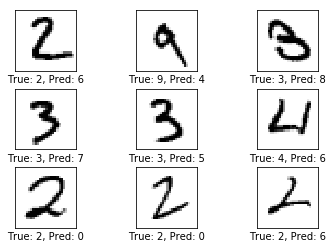

In [13]:
optimize(99)
accuracy_print("test")
plot_example_errors()

iteration num 200
train accuracy:93.3%


iteration num 300
train accuracy:95.0%


iteration num 400
train accuracy:98.3%


iteration num 500
train accuracy:96.7%


iteration num 600
train accuracy:96.7%


iteration num 700
train accuracy:96.7%


iteration num 800
train accuracy:98.3%


iteration num 900
train accuracy:93.3%


iteration num 1000
train accuracy:100.0%


iteration num 1100
train accuracy:100.0%


iteration num 1200
train accuracy:100.0%


iteration num 1300
train accuracy:98.3%


iteration num 1400
train accuracy:98.3%


iteration num 1500
train accuracy:100.0%


iteration num 1600
train accuracy:96.7%


iteration num 1700
train accuracy:96.7%


iteration num 1800
train accuracy:100.0%


iteration num 1900
train accuracy:98.3%


iteration num 2000
train accuracy:96.7%


iteration num 2100
train accuracy:100.0%


iteration num 2200
train accuracy:98.3%


iteration num 2300
train accuracy:100.0%


iteration num 2400
train accuracy:100.0%


iteration num 2500
train accuracy:

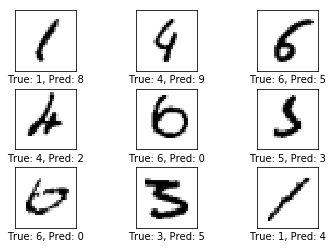

In [14]:
optimize(9000)
accuracy_print("test")
plot_example_errors()

[[ 978    0    0    0    0    0    0    1    1    0]
 [   1 1105   11    1    1    1    1    2   12    0]
 [   4    0 1025    0    0    0    0    2    1    0]
 [   0    0    1 1006    0    3    0    0    0    0]
 [   0    0    2    0  962    0    0    2    1   15]
 [   0    0    1    6    0  884    1    0    0    0]
 [  11    0    3    0    5    5  929    0    5    0]
 [   0    2    3    1    0    0    0 1019    1    2]
 [   2    0    5    2    0    1    0    0  961    3]
 [   1    0    0    2    3    2    0    1    0 1000]]


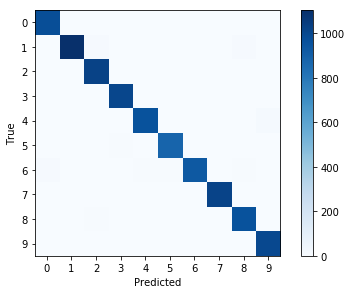

In [15]:
print_confusion_matrix()